# Install Required Packages

In [5]:
# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

#Prophet
from prophet import Prophet

# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# PySpark Core Libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F

# PySpark SQL Functions
from pyspark.sql.functions import (
    col, udf, current_date, monotonically_increasing_id, pandas_udf, PandasUDFType, broadcast, avg
)

# Visualization Style
plt.style.use('fivethirtyeight')

import pyspark.pandas as ps

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
# Create Spark Session
spark = SparkSession.builder \
    .appName("Forecasting") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

In [3]:
# Get SparkContext from the session
sc = spark.sparkContext

# Step 1) Import Data

In [4]:
# structure of the training data set
train_schema = StructType([
  StructField('date', DateType()),
  StructField('store', IntegerType()),
  StructField('item', IntegerType()),
  StructField('sales', IntegerType())
  ])

# read the training file into a dataframe
train = spark.read.csv(
  '/content/drive/MyDrive/CIS731HW/demand-forecasting-kernels-only/train.csv',
  header=True,
  schema=train_schema
  )

# make the dataframe queryable as a temporary view
train.createOrReplaceTempView('train')



Retrieve Data for All Store-Item Combinations

In [9]:
sql_statement = '''
  SELECT
    store,
    item,
    CAST(date as date) as ds,
    SUM(sales) as y
  FROM train
  GROUP BY store, item, ds
  ORDER BY store, item, ds
  '''

store_item_history = (
  spark
    .sql( sql_statement )
    .repartition(sc.defaultParallelism, ['store', 'item'])
  ).cache()

# Data Exploration

In [6]:
# Convert PySpark DataFrame to pandas DataFrame
store_hist = store_item_history.toPandas()

# Convert 'ds' column to datetime in the pandas DataFrame
store_hist['ds'] = pd.to_datetime(store_hist['ds'])


In [ ]:
store_hist.head()

,store,item,ds,y
0,3,1,2013-07-09,32
1,3,1,2014-08-12,26
2,3,1,2014-12-06,19
3,3,1,2015-05-07,31
4,3,1,2015-08-03,22


In [7]:
store_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   store   913000 non-null  int32         
 1   item    913000 non-null  int32         
 2   ds      913000 non-null  datetime64[ns]
 3   y       913000 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 20.9 MB


In [ ]:
store_trend = pd.DataFrame(store_hist.groupby(['ds','store']).sum()['y']).unstack()
store_trend = store_trend.resample('7D',label='left').sum()
store_trend.sort_index(inplace = True)

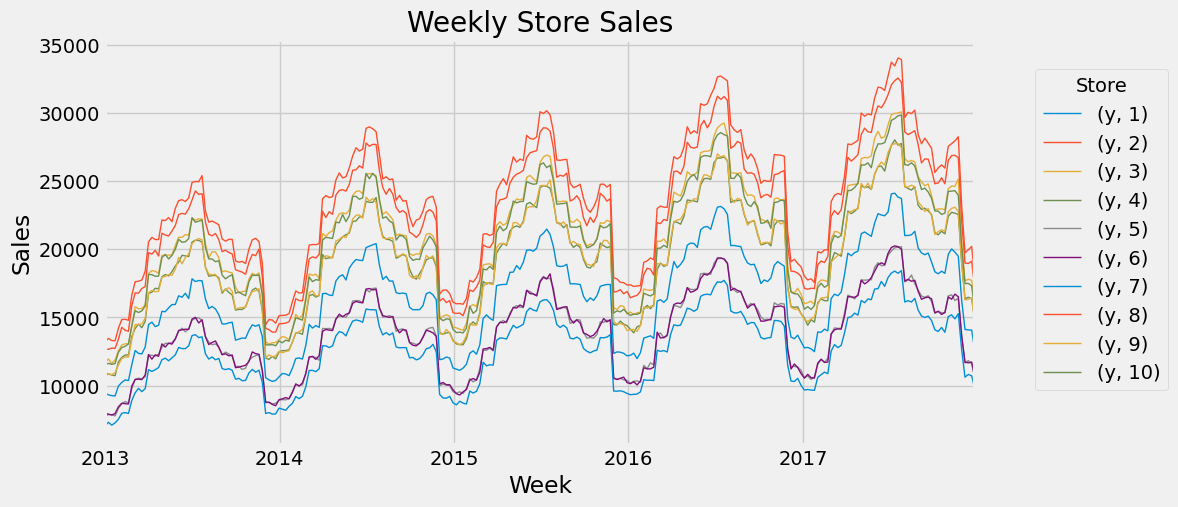

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(10, 5))
store_trend.plot(kind='line', ax=ax, legend=False, linewidth=1) # Plot on the axes and suppress automatic legend
plt.title('Weekly Store Sales')
plt.xlabel('Week')
plt.ylabel('Sales')
fig.legend(title='Store', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
item_trend = pd.DataFrame(store_hist.groupby(['ds','item']).sum()['y']).unstack()
item_trend = item_trend.resample('7D',label='left').sum()
item_trend.sort_index(inplace = True)

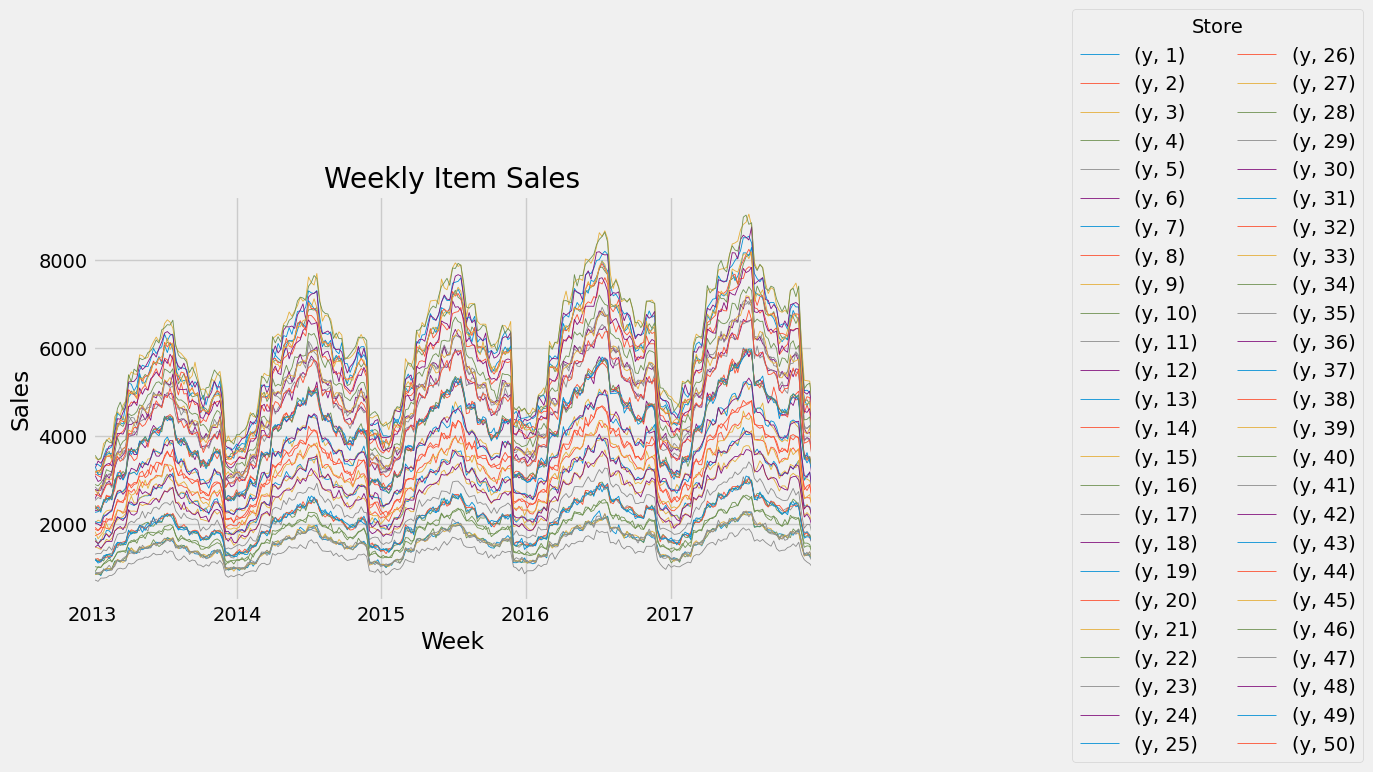

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(10, 5))
item_trend.plot(kind='line', ax=ax, legend=False, linewidth=0.6)
plt.title('Weekly Item Sales')
plt.xlabel('Week')
plt.ylabel('Sales')
fig.legend(title='Store', loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)
plt.subplots_adjust(right=0.8)
plt.show()

In [ ]:
#Split the dates
df = store_item_history.withColumn('split_date', F.split(store_item_history.ds, '-'))

# create month and year columns
df = df.withColumn('year', df.split_date.getItem(0))
df = df.withColumn('day', df.split_date.getItem(F.size('split_date') - 1))
df = df.withColumn('month', df.split_date.getItem(1))
#show alternate table with
df.show(10)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+-----+----+----------+---+--------------+----+---+-----+
|store|item|        ds|  y|    split_date|year|day|month|
+-----+----+----------+---+--------------+----+---+-----+
|    3|   1|2013-07-09| 32|[2013, 07, 09]|2013| 09|   07|
|    3|   1|2014-08-12| 26|[2014, 08, 12]|2014| 12|   08|
|    3|   1|2014-12-06| 19|[2014, 12, 06]|2014| 06|   12|
|    3|   1|2015-05-07| 31|[2015, 05, 07]|2015| 07|   05|
|    3|   1|2015-08-03| 22|[2015, 08, 03]|2015| 03|   08|
|    3|   1|2015-12-22| 16|[2015, 12, 22]|2015| 22|   12|
|    3|   1|2016-04-03| 41|[2016, 04, 03]|2016| 03|   04|
|    4|   1|2013-03-06| 16|[2013, 03, 06]|2013| 06|   03|
|    4|   1|2013-05-01| 20|[2013, 05, 01]|2013| 01|   05|
|    4|   1|2013-06-18| 19|[2013, 06, 18]|2013| 18|   06|
+-----+----+----------+---+--------------+----+---+-----+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import dayofweek, date_format

# Encode Day of Week by numbers
df = df.withColumn('day_of_week', dayofweek(df['ds']))

#Convert Day of Week Number to Name
df = df.withColumn('day_of_week_name', date_format(df['ds'], 'EEEE'))
df.show(10)


+-----+----+----------+---+--------------+----+---------+-----+-----------+----------------+----------+
|store|item|        ds|  y|    split_date|year|      Day|month|day_of_week|day_of_week_name|month_name|
+-----+----+----------+---+--------------+----+---------+-----+-----------+----------------+----------+
|    3|   1|2013-07-09| 32|[2013, 07, 09]|2013|  Tuesday|    7|          3|         Tuesday|      July|
|    3|   1|2014-08-12| 26|[2014, 08, 12]|2014|  Tuesday|    8|          3|         Tuesday|    August|
|    3|   1|2014-12-06| 19|[2014, 12, 06]|2014| Saturday|   12|          7|        Saturday|  December|
|    3|   1|2015-05-07| 31|[2015, 05, 07]|2015| Thursday|    5|          5|        Thursday|       May|
|    3|   1|2015-08-03| 22|[2015, 08, 03]|2015|   Monday|    8|          2|          Monday|    August|
|    3|   1|2015-12-22| 16|[2015, 12, 22]|2015|  Tuesday|   12|          3|         Tuesday|  December|
|    3|   1|2016-04-03| 41|[2016, 04, 03]|2016|   Sunday|    4| 

<Figure size 1200x600 with 0 Axes>

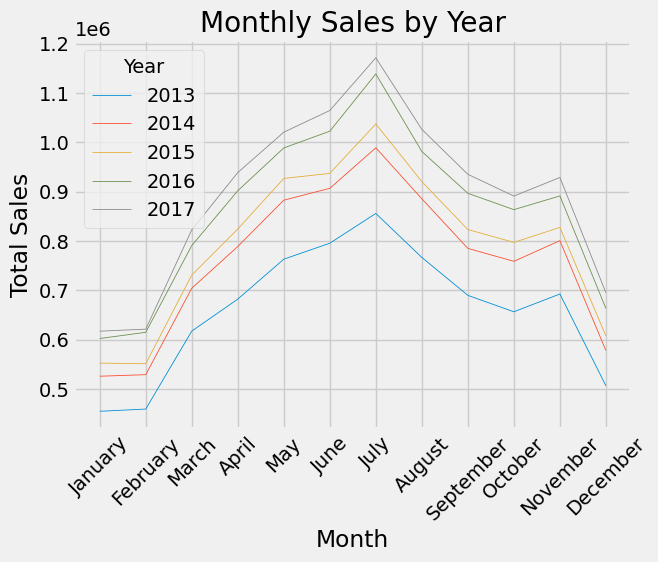

In [ ]:
from pyspark.sql.functions import year, month, date_format

# Extract Year and Month
df = df.withColumn('year', year(df['ds']))
df = df.withColumn('month', month(df['ds']))

# Convert Month Number to Name
df = df.withColumn('month_name', date_format(df['ds'], 'MMMM'))

# Group and Aggregate Sales by Year and Month
monthly_sales_by_year = (df
    .groupBy('year', 'month_name')
    .agg(F.sum('y').alias('total_sales'))
    .toPandas()
)

monthly_sales_pivot = monthly_sales_by_year.pivot(index='month_name', columns='year', values='total_sales')

month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
monthly_sales_pivot = monthly_sales_pivot.reindex(month_order)

# plot
plt.figure(figsize=(12, 6))
monthly_sales_pivot.plot(kind='line', legend=False, linewidth=0.6,
                        xticks=range(len(month_order)),
                        rot=45)
plt.title('Monthly Sales by Year')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.gca().set_xticklabels(month_order)
plt.legend(title='Year')
plt.show()

# Build Prophet Model

In [13]:
pip install prophet

In [14]:
prophet_model = (
  spark
    .sql( sql_statement )
    .repartition(sc.defaultParallelism, ['store', 'item'])
  ).cache()

In [15]:
result_schema =StructType([
  StructField('ds',DateType()),
  StructField('store',IntegerType()),
  StructField('item',IntegerType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

Define Function to Train Model & Generate Forecast

In [16]:
def forecast_store_item( phistory_pd: pd.DataFrame ) -> pd.DataFrame:

  # TRAIN MODEL AS BEFORE
  # --------------------------------------
  # remove missing values (more likely at day-store-item level)
  phistory_pd = phistory_pd.dropna()

  # configure the model
  model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
    )

  # train the model
  model.fit( phistory_pd )
  # --------------------------------------

  # BUILD FORECAST AS BEFORE
  # --------------------------------------
  # make predictions
  future_pd = model.make_future_dataframe(
    periods=90,
    freq='d',
    include_history=True
    )
  forecast_pd = model.predict( future_pd )
  # --------------------------------------

  # ASSEMBLE EXPECTED RESULT SET
  # --------------------------------------
  # get relevant fields from forecast
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')

  # get relevant fields from history
  h_pd = phistory_pd[['ds','store','item','y']].set_index('ds')

  # join history and forecast
  results_pd = f_pd.join( h_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)

  # get store & item from incoming data set
  results_pd['store'] = phistory_pd['store'].iloc[0]
  results_pd['item'] = phistory_pd['item'].iloc[0]
  # --------------------------------------

  # return expected dataset
  return results_pd[ ['ds', 'store', 'item', 'y', 'yhat', 'yhat_upper', 'yhat_lower'] ]

In [17]:
results = (
  prophet_model
    .groupBy('store', 'item')
      .applyInPandas(forecast_store_item, schema=result_schema)
    .withColumn('training_date', current_date() )
    )

#results.createOrReplaceTempView('new_pforecasts')

#results.show(5)

save as parquet for future evaluation

In [18]:
# Filter for 2017 and future forecasts
prophet_2017_cleaned = results.filter(col("ds").between("2017-01-01", "2017-12-31")) \
                              .select("ds", "store", "item", "y", "yhat")

prophet_future_cleaned = results.filter(col("ds") > "2017-12-31") \
                                .select("ds", "store", "item", "yhat")

# Define Parquet file paths
prophet_2017_path = '/content/drive/MyDrive/CIS731HW/2017_prophet.parquet'
prophet_future_path = '/content/drive/MyDrive/CIS731HW/prophetFC.parquet'

# Save cleaned DataFrames as Parquet files
prophet_2017_cleaned.write.mode('overwrite').parquet(prophet_2017_path)
prophet_future_cleaned.write.mode('overwrite').parquet(prophet_future_path)

# Load the saved Parquet files
prophet_2017 = spark.read.parquet(prophet_2017_path)
prophet_fc = spark.read.parquet(prophet_future_path)

# Verify loading
prophet_2017.show(5)
prophet_fc.show(5)

+----------+-----+----+----+---------+
|        ds|store|item|   y|     yhat|
+----------+-----+----+----+---------+
|2017-01-01|    1|   1|19.0|20.331572|
|2017-01-02|    1|   1|15.0|11.247568|
|2017-01-03|    1|   1|10.0|14.165883|
|2017-01-04|    1|   1|16.0|14.801251|
|2017-01-05|    1|   1|14.0|15.505549|
+----------+-----+----+----+---------+
only showing top 5 rows

+----------+-----+----+---------+
|        ds|store|item|     yhat|
+----------+-----+----+---------+
|2018-01-01|    1|   1|11.552864|
|2018-01-02|    1|   1|14.578373|
|2018-01-03|    1|   1|15.254037|
|2018-01-04|    1|   1|15.998933|
|2018-01-05|    1|   1|17.709871|
+----------+-----+----+---------+
only showing top 5 rows



# Build XGBoost Model



Create Features

In [19]:
def create_features(df):
    # Create lag features
    df['lag_1'] = df['y'].shift(1)  # Previous day's sales
    df['lag_2'] = df['y'].shift(2)  # Sales three days ago
    df['lag_3'] = df['y'].shift(3)
    # Create rolling mean feature
    df['rolling_mean_3'] = df['y'].rolling(window=3).mean()

    # Extract year, month, day, and day of the week from the date
    df['year'] = pd.to_datetime(df['ds']).dt.year  # Year as a feature
    df['month'] = pd.to_datetime(df['ds']).dt.month  # Month as a feature
    df['day'] = pd.to_datetime(df['ds']).dt.day  # Day of month
    df['day_of_week'] = pd.to_datetime(df['ds']).dt.dayofweek  # Day of the week (Monday=0, Sunday=6)

    # Binary features for weekends
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    # Drop rows with NaN values
    df = df.dropna()

    return df


In [20]:
# Define forecast schema
forecast_schema = StructType([
    StructField('ds', DateType()),
    StructField('store', IntegerType()),
    StructField('item', IntegerType()),
    StructField('y', FloatType()),  # Actual values
    StructField('yhat', FloatType()),  # Predicted values
    StructField('training_date', DateType())
])

@pandas_udf(forecast_schema, PandasUDFType.GROUPED_MAP)
def forecast_last_year(history_pd: pd.DataFrame) -> pd.DataFrame:
    """
    Forecasts sales for the last year of the data.
    """

    history_pd = create_features(history_pd)
    history_pd = history_pd.sort_values(by=['ds'])

    # Calculate cutoff date for the last year
    cutoff_date = history_pd['ds'].max() - pd.DateOffset(days=364)

    # Convertto a Pandas
    cutoff_date = pd.Timestamp(cutoff_date)

    # Convert 'ds' column to Pandas for comparing
    history_pd['ds'] = pd.to_datetime(history_pd['ds'])

    # Split into training and testing sets (80/20)
    train_data = history_pd[history_pd['ds'] <= cutoff_date]
    test_data = history_pd[history_pd['ds'] > cutoff_date]

    # Prepare data for XGBoost
    X_train = train_data[['lag_1','lag_2', 'lag_3', 'rolling_mean_3', 'year', 'month', 'day', 'day_of_week', 'is_weekend']]
    y_train = train_data['y']
    X_test = test_data[['lag_1', 'lag_2','lag_3', 'rolling_mean_3', 'year', 'month', 'day', 'day_of_week', 'is_weekend']]

    # Train the model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Plot the importance
    plot_importance(model, height=0.9)
    plt.show()  # Display the plot

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Create a DataFrame for results
    results_df = pd.DataFrame({
        'ds': test_data['ds'],
        'store': test_data['store'],
        'item': test_data['item'],
        'y': test_data['y'],  # Actual values
        'yhat': predictions,    # Predicted values
        'training_date': pd.to_datetime('now')
    })

    return results_df

# Apply the UDF
all_forecasts = store_item_history.groupBy('store', 'item').apply(forecast_last_year)

# Show the results
#all_forecasts.show(5)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [21]:
save_path = '/content/drive/MyDrive/CIS731HW/all_forecasts.parquet'

# Save DataFrame to Parquet file
all_forecasts.write.mode('overwrite').parquet(save_path)
print(f"Data saved to {save_path}")


Data saved to /content/drive/MyDrive/CIS731HW/all_forecasts.parquet


In [23]:
# Load the saved Parquet file
xgb_forecasts = spark.read.parquet(save_path)


# Evaluation

In [24]:
from pyspark.sql.functions import col, abs, pow, avg, expr
# Prophet
metrics_prophet = prophet_2017.withColumn("abs_error", abs(col("y") - col("yhat"))) \
                                   .withColumn("squared_error", pow(col("y") - col("yhat"), 2)) \
                                   .withColumn("percentage_error", abs((col("y") - col("yhat")) / col("y")))

# aggregate
metrics_prophet_agg = metrics_prophet.agg(
    avg("abs_error").alias("MAE"),
    expr("sqrt(avg(squared_error))").alias("RMSE"),
    avg("percentage_error").alias("MAPE")
)
metrics_prophet_agg.show()

+-----------------+----------------+-------------------+
|              MAE|            RMSE|               MAPE|
+-----------------+----------------+-------------------+
|6.187214051424314|8.04680045524018|0.12734818175715767|
+-----------------+----------------+-------------------+



In [25]:
#Metrics for XGBoost
metrics_xgb = xgb_forecasts.withColumn("abs_error", abs(col("y") - col("yhat"))) \
                           .withColumn("squared_error", pow(col("y") - col("yhat"), 2)) \
                           .withColumn("percentage_error", abs((col("y") - col("yhat")) / col("y")))

# aggregate XGBoost Metrics
metrics_xgb_agg = metrics_xgb.agg(
    avg("abs_error").alias("MAE"),
    expr("sqrt(avg(squared_error))").alias("RMSE"),
    avg("percentage_error").alias("MAPE")
)
metrics_xgb_agg.show()


+-----------------+-----------------+-------------------+
|              MAE|             RMSE|               MAPE|
+-----------------+-----------------+-------------------+
|3.520567536279932|5.142572862759678|0.06331400959316848|
+-----------------+-----------------+-------------------+



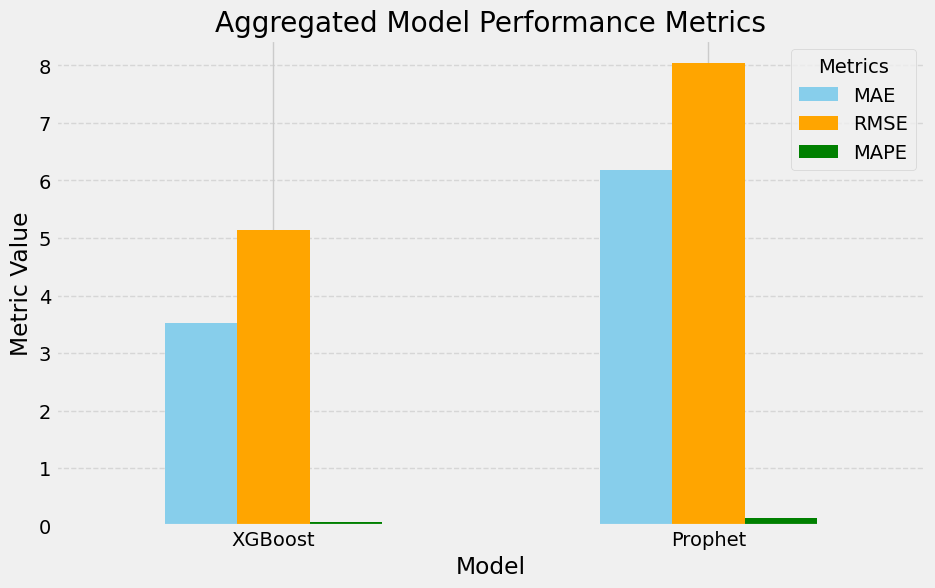

In [33]:
# Convert Spark Df to Pandas
metrics_xgb_pd = metrics_xgb_agg.toPandas()
metrics_prophet_pd = metrics_prophet_agg.toPandas()

# identify the models
metrics_xgb_pd["Model"] = "XGBoost"
metrics_prophet_pd["Model"] = "Prophet"

# Combine to single DataFrame
comparison_df = pd.concat([metrics_xgb_pd, metrics_prophet_pd], ignore_index=True)

# Plot
comparison_df.set_index("Model")[['MAE', 'RMSE', 'MAPE']].plot(
    kind="bar", figsize=(10, 6), color=["skyblue", "orange", "green"]
)
1
plt.title("Aggregated Model Performance Metrics")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Metrics", loc="upper right")
plt.show()

Metrics by store

In [34]:
# Group by Store for XGBoost
metrics_by_store_xgb = metrics_xgb.groupBy("store").agg(
    avg("abs_error").alias("MAE"),
    expr("sqrt(avg(squared_error))").alias("RMSE"),
    avg("percentage_error").alias("MAPE")
)
metrics_by_store_xgb.orderBy('store').show()

# Group by Storefor Prophet
metrics_by_store_prophet = metrics_prophet.groupBy("store").agg(
    avg("abs_error").alias("MAE"),
    expr("sqrt(avg(squared_error))").alias("RMSE"),
    avg("percentage_error").alias("MAPE")
)
metrics_by_store_prophet.show()


+-----+------------------+------------------+--------------------+
|store|               MAE|              RMSE|                MAPE|
+-----+------------------+------------------+--------------------+
|    1|3.2005497131977316|  4.63168447569311|  0.0636273526096618|
|    2| 4.455480509466843| 6.345360406320505| 0.06174464637239984|
|    3|3.9072556664579117| 5.541608999379249| 0.06115639083459114|
|    4|3.7141710919866737| 5.290461381482846| 0.06347287929423819|
|    5|  2.75593833863499| 4.032594135306644|  0.0656154209926161|
|    6|2.7274016336789417| 4.009462368713979| 0.06414102822640201|
|    7|  2.50668556161199| 3.720399736323659| 0.06492311468692219|
|    8| 4.294450727668259|6.1320312999631446|0.061793513053553184|
|    9|3.7243459970800337|  5.41874230202319| 0.06339274588395298|
|   10|3.9188469993851642| 5.558429429760662| 0.06327478251391233|
+-----+------------------+------------------+--------------------+

+-----+-----------------+------------------+-----------------

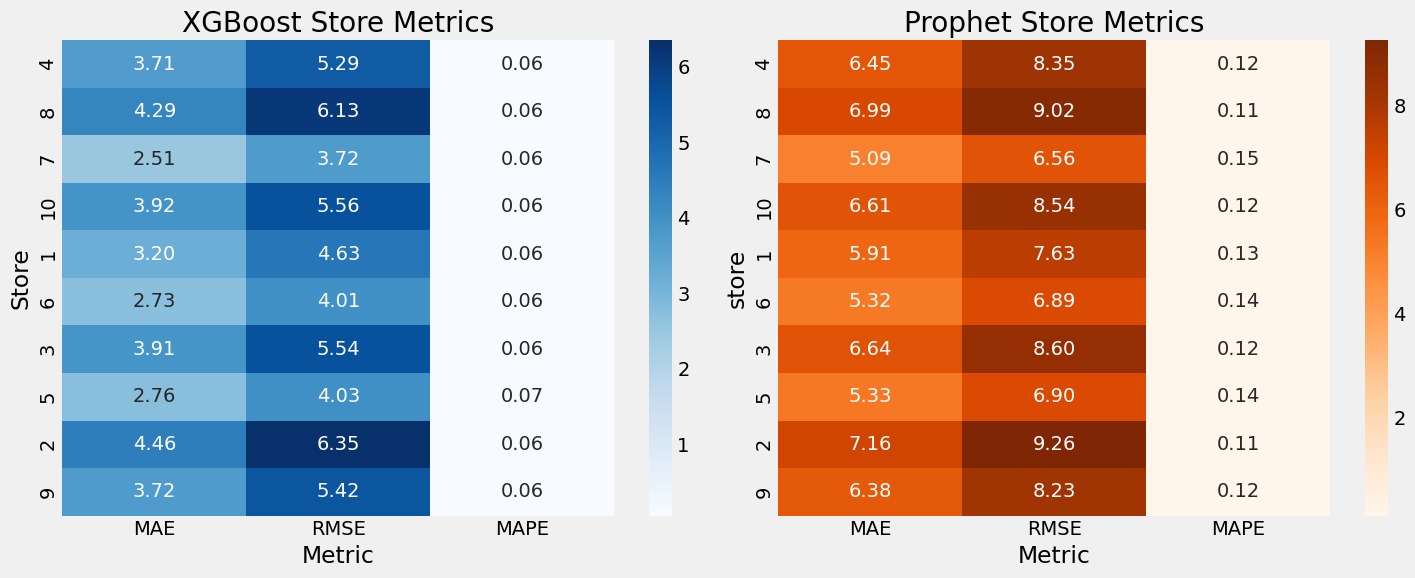

In [35]:
# Convert to pandas DataFrame first
metrics_by_store_xgb_pd = metrics_by_store_xgb.toPandas()
metrics_by_store_prophet_pd = metrics_by_store_prophet.toPandas()

#create heatmap data
heatmap_df_xgb = metrics_by_store_xgb_pd.set_index("store")[['MAE', 'RMSE', 'MAPE']]
heatmap_df_prophet = metrics_by_store_prophet_pd.set_index("store")[['MAE', 'RMSE', 'MAPE']]

# Plot
#XGboost
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(
    heatmap_df_xgb, cmap="Blues", annot=True, fmt=".2f", ax=axes[0]
)
axes[0].set_title("XGBoost Store Metrics")
axes[0].set_ylabel("Store")
axes[0].set_xlabel("Metric")
#Prophet
sns.heatmap(
    heatmap_df_prophet, cmap="Oranges", annot=True, fmt=".2f", ax=axes[1]
)
axes[1].set_title("Prophet Store Metrics")
axes[1].set_xlabel("Metric")

plt.tight_layout()
plt.show()


In [42]:
from scipy.stats import ttest_rel

# Define function for one-sided paired t-test
def perform_one_sided_ttest(metric_xgb, metric_prophet, metric_name):
    t_stat, p_value = ttest_rel(metric_xgb, metric_prophet, alternative='less')
    print(f"{metric_name} T-Statistic: {t_stat:.4f}")
    print(f"{metric_name} P-Value: {p_value:.4e}")

    if p_value < 0.05:
        print(f"Reject the null hypothesis for {metric_name}: XGBoost performs significantly better.\n")
    else:
        print(f"Fail to reject the null hypothesis for {metric_name}: No significant evidence that XGBoost performs better.\n")


# Convert PySpark to pandas DataFrames
mae_xgb = metrics_by_store_xgb.select("MAE").toPandas()["MAE"].tolist()
mae_prophet = metrics_by_store_prophet.select("MAE").toPandas()["MAE"].tolist()

rmse_xgb = metrics_by_store_xgb.select("RMSE").toPandas()["RMSE"].tolist()
rmse_prophet = metrics_by_store_prophet.select("RMSE").toPandas()["RMSE"].tolist()

mape_xgb = metrics_by_store_xgb.select("MAPE").toPandas()["MAPE"].tolist()
mape_prophet = metrics_by_store_prophet.select("MAPE").toPandas()["MAPE"].tolist()

# Run T-tests for MAE, RMSE, and MAPE
perform_one_sided_ttest(mae_xgb, mae_prophet, "MAE")
perform_one_sided_ttest(rmse_xgb, rmse_prophet, "RMSE")
perform_one_sided_ttest(mape_xgb, mape_prophet, "MAPE")

MAE T-Statistic: -134.7186
MAE P-Value: 1.7382e-16
Reject the null hypothesis for MAE: XGBoost performs significantly better.

RMSE T-Statistic: -104.8531
RMSE P-Value: 1.6564e-15
Reject the null hypothesis for RMSE: XGBoost performs significantly better.

MAPE T-Statistic: -15.4742
MAPE P-Value: 4.3032e-08
Reject the null hypothesis for MAPE: XGBoost performs significantly better.



# Forecast 90 days out

In [74]:
@pandas_udf(forecast_schema, PandasUDFType.GROUPED_MAP)
def forecast_future_90_days(history_pd: pd.DataFrame) -> pd.DataFrame:
    """
    Forecasts sales for next 90 days with xgboost model
    """

    history_pd['year'] = pd.to_datetime(history_pd['ds']).dt.year
    history_pd['month'] = pd.to_datetime(history_pd['ds']).dt.month
    history_pd['day'] = pd.to_datetime(history_pd['ds']).dt.day
    history_pd['day_of_week'] = pd.to_datetime(history_pd['ds']).dt.dayofweek
    history_pd['is_weekend'] = (history_pd['day_of_week'] >= 5).astype(int)
    last_date = history_pd['ds'].max()

    # Prepare future data for prediction
    future_data = pd.DataFrame({'ds': pd.date_range(start=last_date + pd.DateOffset(days=1), periods=90, freq='D')})
    future_data['store'] = history_pd['store'].iloc[0]
    future_data['item'] = history_pd['item'].iloc[0]
    future_data['y'] = 0

    # Engineer time-based features
    future_data['year'] = pd.to_datetime(future_data['ds']).dt.year
    future_data['month'] = pd.to_datetime(future_data['ds']).dt.month
    future_data['day'] = pd.to_datetime(future_data['ds']).dt.day
    future_data['day_of_week'] = pd.to_datetime(future_data['ds']).dt.dayofweek
    # Create 'is_weekend' column in future_data
    future_data['is_weekend'] = (future_data['day_of_week'] >= 5).astype(int)

    # Train the model
    X_train = history_pd[['year', 'month', 'day', 'day_of_week', 'is_weekend']]
    y_train = history_pd['y']
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Predict
    X_future = future_data[['year', 'month', 'day', 'day_of_week', 'is_weekend']]
    future_data['yhat'] = model.predict(X_future)

    # Create DataFrame
    results_df = pd.DataFrame({
        'ds': future_data['ds'].dt.date,
        'store': future_data['store'],
        'item': future_data['item'],
        'y': future_data['y'],
        'yhat': future_data['yhat'],
        'training_date': pd.Timestamp.now().floor('D')
    })
    return results_df

In [75]:
# Apply UDF to make forecasts
future_forecasts = store_item_history.groupBy('store', 'item').apply(forecast_future_90_days)

# Collect Results
future_forecasts_pd = future_forecasts.toPandas()

# View the results
#print(future_forecasts_pd)

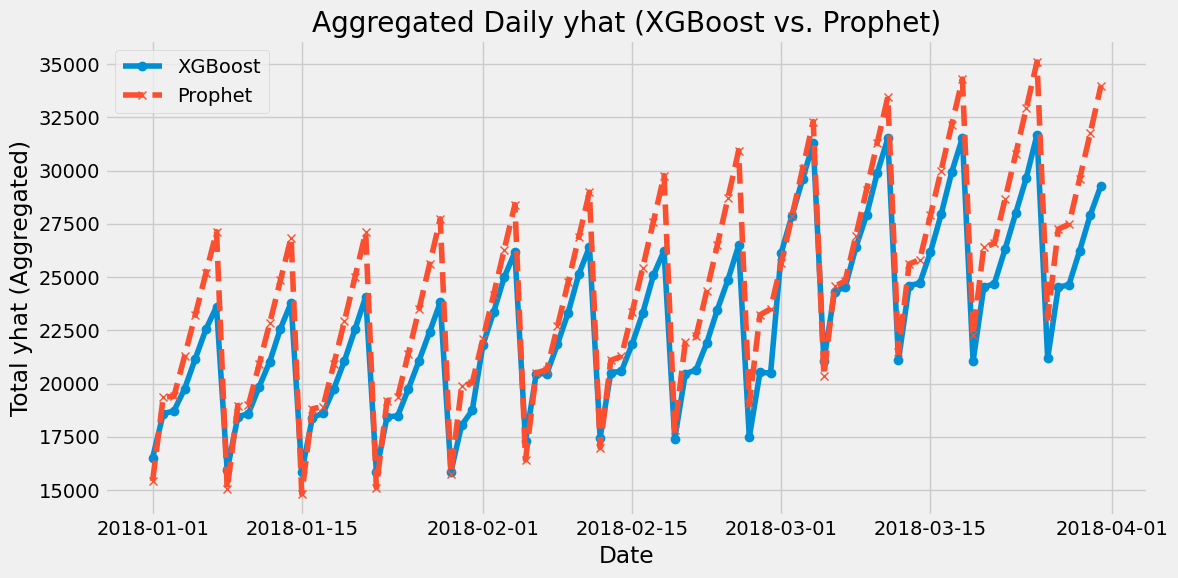

In [85]:
daily_yhat_future = future_forecasts_pd.groupby('ds')['yhat'].sum().reset_index()
prophet_fc_pd = prophet_fc.toPandas()
daily_yhat_prophet = prophet_fc_pd.groupby('ds')['yhat'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_yhat_future['ds'], daily_yhat_future['yhat'], marker='o', linestyle='-', label='XGBoost')

# Plot prophet_fc
plt.plot(daily_yhat_prophet['ds'], daily_yhat_prophet['yhat'], marker='x', linestyle='--', label='Prophet')

plt.title('Aggregated Daily yhat (XGBoost vs. Prophet)')
plt.xlabel('Date')
plt.ylabel('Total yhat (Aggregated)')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()